phase list size:  700  amp list size:  700


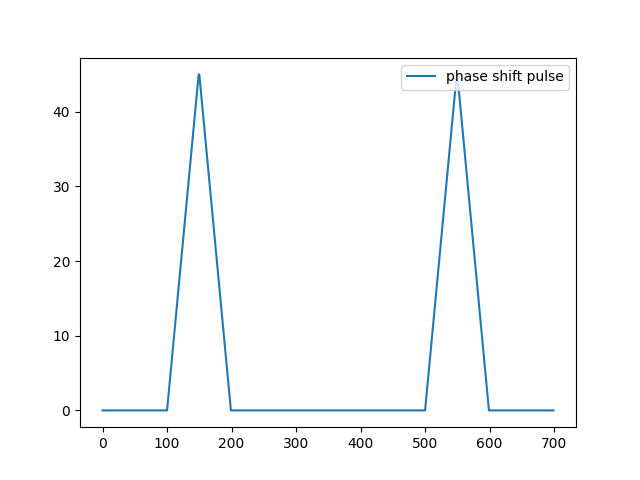

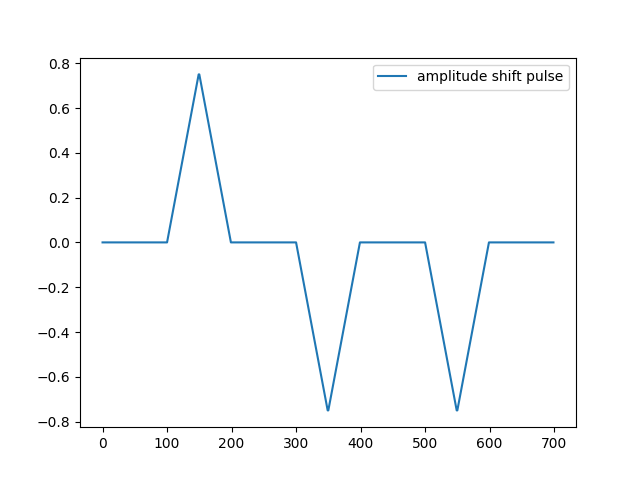

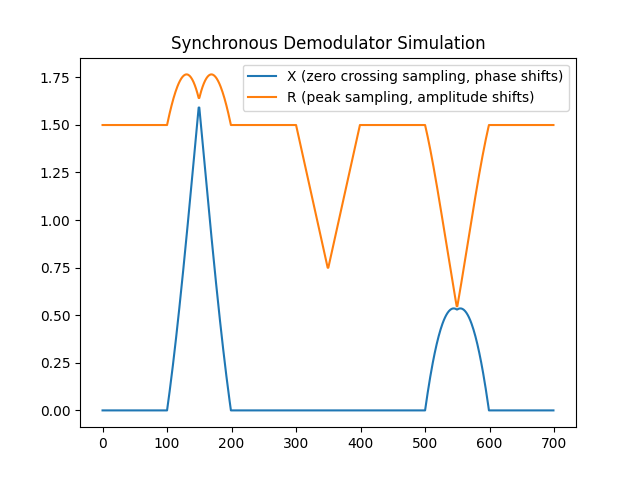

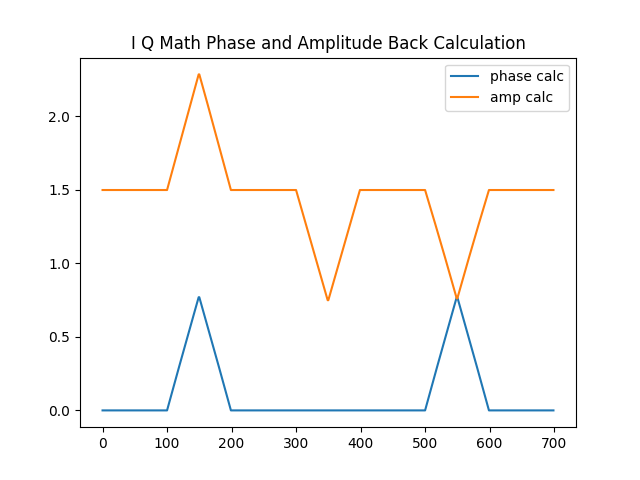

In [11]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import math as m

# wave and sampling parameters
sampleRate = 500000.0
frequency = 10000.0
amplitude = 1.5
numCycles = 1

# wave and sampling calculations
period = 1.0/frequency #seconds per cycle
samplesPerCycle = sampleRate/frequency

# set up the plot
#plt.axhline(y = 0.0, color = 'g', linestyle = '--') 

phaseMax = 45.0
phasePulseList = np.concatenate((
    np.zeros(100), 
    np.linspace(0, 1, 50) * phaseMax, 
    np.linspace(1, 0, 50) * phaseMax,
    np.zeros(100),
    np.zeros(50),
    np.zeros(50),
    np.zeros(100),
    np.linspace(0, 1, 50) * phaseMax, 
    np.linspace(1, 0, 50) * phaseMax,
    np.zeros(100), 
))

ampMax = 0.75
ampPulseList = np.concatenate((
    np.zeros(100), 
    np.linspace(0, 1, 50) * ampMax, 
    np.linspace(1, 0, 50) * ampMax,
    np.zeros(100),
    np.linspace(0, -1, 50) * ampMax, 
    np.linspace(-1, 0, 50) * ampMax,
    np.zeros(100),
    np.linspace(0, -1, 50) * ampMax, 
    np.linspace(-1, 0, 50) * ampMax,
    np.zeros(100), 
))

fig = plt.figure()
plt.plot(phasePulseList, label="phase shift pulse")
plt.legend(loc="upper right")
fig = plt.figure()
plt.plot(ampPulseList, label="amplitude shift pulse")
plt.legend(loc="upper right")

if phasePulseList.size != ampPulseList.size:
    print("Error: phase and amp list sizes don't match")
    exit()

print("phase list size: ", phasePulseList.size, " amp list size: ", ampPulseList.size)

fig = plt.figure()

signalX = []
signalR = []
signalPhaseCalc = []
signalAmpCalc = []
for i in range(0, phasePulseList.size):
    phase = phasePulseList[i]
    finalAmplitude = amplitude + ampPulseList[i];
    signal = finalAmplitude * np.sin(np.linspace(0, period * numCycles, int(samplesPerCycle*numCycles)) * 2*np.pi*frequency + np.deg2rad(phase))
    #plt.plot(signal, label="phase: " + str(phase))
    sampleX = signal[0]
    signalX.append(sampleX)
    sampleR = signal[int(samplesPerCycle/4)]
    signalR.append(sampleR)

    phaseCalc = m.atan2(sampleX, sampleR)
    signalPhaseCalc.append(phaseCalc)
    ampCalc = m.sqrt(sampleX*sampleX + sampleR*sampleR)
    signalAmpCalc.append(ampCalc)

    #print("phase: ", phase, " X: ", sampleX, " R: ", sampleR)


plt.title("Synchronous Demodulator Simulation")
plt.plot(signalX, label="X (zero crossing sampling, phase shifts)")
plt.plot(signalR, label="R (peak sampling, amplitude shifts)")
plt.legend(loc="upper right")

fig = plt.figure()
plt.title("I Q Math Phase and Amplitude Back Calculation")
plt.plot(signalPhaseCalc, label="phase calc")
plt.plot(signalAmpCalc, label="amp calc")
plt.legend(loc="upper right")